In [2]:
import requests
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The following code joins two datasets of tweets from 2017 and 2019, though many of the same tweets can be found in both. Since these datasets only contain the tweet ids, we had to use Twitter's API to pull the attached tweets.

The final number of tweets in our resulting dataset is 9,733. This is smaller than the 2019 dataset because some were no longer accessable. Also, since you now have to pay for the API, pulling more than 10,000 tweets would have greatly increased our budget.

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pull Tweets using Twitter's API
### (this has already been done so skip this section to load the resulting data)

In [1]:
# Requires Token for Twitter API to run this section
token=""

In [6]:
#import original data set
url="/content/drive/MyDrive/PHM2017.txt"
df=pd.read_csv(url,sep='\t')
print(f'length: {len(df)}')
df.head()

length: 7191


,811711269212483584,alzheimer,2
0,811746810733723649,alzheimer,1
1,902649153792098304,alzheimer,1
2,811695298359783424,alzheimer,0
3,811696543501864961,alzheimer,1
4,813212976257896449,alzheimer,1


In [ ]:
#functions to pull tweets
def tweets(tweet_ids_list):

    bearer_token = token

    def create_url():
        tweet_fields = "tweet.fields=lang,author_id"
        ids = "ids=" + ",".join(map(str, tweet_ids_list))
        url = f"https://api.twitter.com/2/tweets?{ids}&{tweet_fields}"
        return url

    def bearer_oauth(r):
        r.headers["Authorization"] = f"Bearer {bearer_token}"
        r.headers["User-Agent"] = "v2TweetLookupPython"
        return r

    def connect_to_endpoint(url):
        response = requests.request("GET", url, auth=bearer_oauth)
        if response.status_code != 200:
            raise Exception(f"Request returned an error: {response.status_code} {response.text}")
        return response.json()

    return connect_to_endpoint(create_url())


In [ ]:
#pulls and dumps tweets into json file

file_name = 'tweets.json'
tweet_indx_start = 7176 #first tweet index to pull
tweet_indx_end = 7193 #pull until this index
stop_at = 8000 # continue pulling until it surpasses this number
offset = tweet_indx_end-tweet_indx_start #update start and end index for continuous pulls
sleep=65 #how long to sleep after each pull

#run
if __name__ == "__main__":
    all_responses = []


    #read existing data from the file
    try:
        with open('tweets.json', 'r') as f:
            existing_data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        existing_data = []

    while tweet_indx_end <= stop_at:
        tweet_indx_start += offset
        tweet_indx_end += offset
        the_ids = df[tweet_indx_start:tweet_indx_end]['tweet_id'].to_list()
        print(f'tweet index: {tweet_indx_start}-{tweet_indx_end}')

        #fetch tweets in batches
        response = tweets(the_ids)
        all_responses.append(response)

        #sleep between pulls
        time.sleep(sleep)

    #merge existing data with new data
    combined_data = existing_data + all_responses

    with open(file_name, 'w') as f:
        json.dump(combined_data, f, indent=4)


In [ ]:
with open('tweets.json', 'r') as f:
    json_data1 = json.load(f)

#loops through resulting json file and creates two data frames for successful and failed pulls
tweets_df=pd.DataFrame(json_data1[0]['data'])
errors_df=pd.DataFrame(json_data1[1]['errors'])
for json1 in json_data1:
    the_keys=(json1.keys())
    for key in the_keys:
        if key == 'data':
            tweets_df=pd.concat([tweets_df,pd.DataFrame(json1[key])],ignore_index=True)
        elif key == 'errors':
            errors_df=pd.concat([errors_df,pd.DataFrame(json1[key])],ignore_index=True)
        else:
            print(key)

In [ ]:
#rename column to prepare for merge
tweets_df.rename(columns={'id':'tweet_id'},inplace=True)

In [ ]:
#eliminate unneeded columns and rename others
errors_df=errors_df[['tweet_id']]
errors_df['text']='unavailable'

In [ ]:
#concatenate errors_df with tweets_df
tweets_df=pd.concat([tweets_df[['tweet_id','text']],errors_df],ignore_index=True)

In [ ]:
#drop duplicates
tweets_df=tweets_df.drop_duplicates()

In [ ]:
#merge tweets_df with the main df
tweets_df.tweet_id=tweets_df.tweet_id.astype(int)
df=df.merge(tweets_df, on = 'tweet_id')

In [ ]:
#align ratings with the newer data set (they reduced it from four to three different classifications)

#load newer data set
tw_df2=pd.read_csv('hmc2019.txt')

#set tweet_id to index temporarily
df.set_index('tweet_id', inplace=True)
tw_df2.set_index('tweet_id', inplace=True)

#update ratings to match
df['rating'].update(tw_df2['rating'])

#reset index
df.reset_index(inplace=True)
tw_df2.reset_index(inplace=True)

In [ ]:
#save to csv
df.to_csv('PHM2017_with_tweets.csv')

### Evaluate Original Dataset  - 2017

In [7]:
df=pd.read_csv('/content/drive/MyDrive/PHM2017_with_tweets.csv')
df.head()

,Unnamed: 0,tweet_id,health_word,rating,text
0,0,8.117468e+17,alzheimer,1.0,New Alzheimer Society resources to support a m...
1,1,9.026492e+17,alzheimer,1.0,unavailable
2,2,8.116953e+17,alzheimer,0.0,unavailable
3,3,8.116965e+17,alzheimer,1.0,unavailable
4,4,8.132130e+17,alzheimer,1.0,What to Know About Thyroid and Alzheimer's htt...


In [9]:
print(df.rating.value_counts())

1.0    3601
0.0    2178
2.0     813
3.0     599
Name: rating, dtype: int64


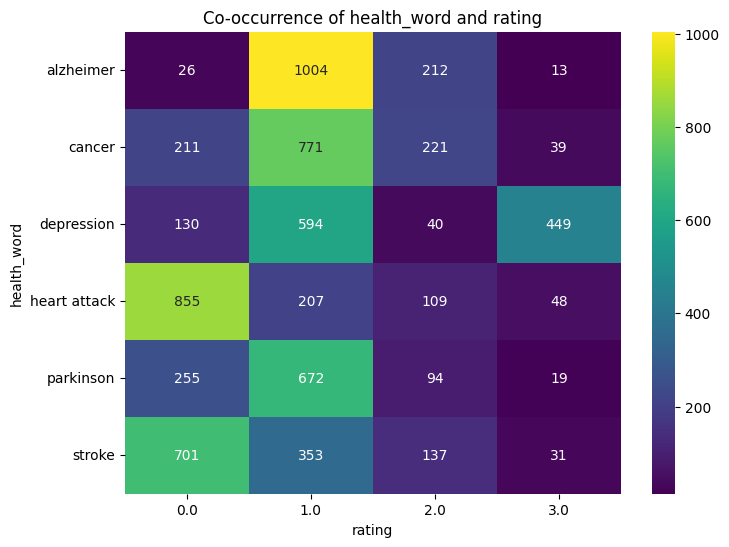

In [11]:
# Create a cross-tabulation of the two columns
cross_tab = pd.crosstab(df['health_word'], df['rating'])

# Visualize the cross-tabulation as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cross_tab, annot=True, cmap='viridis', fmt='g')
plt.title('Co-occurrence of health_word and rating')
plt.show()

### Newer Data Set - 2019

In [12]:
#get the indices of rows in newer df that have a tweet_id present in original df
mask = tw_df2['tweet_id'].isin(df['tweet_id'])

# Use boolean indexing to filter out those rows
tw_df = tw_df2[~mask]

In [ ]:
#make sure there are no overlapping tweet_ids - True if it evaluates to 0
len(tw_df[tw_df['tweet_id'].isin(df['tweet_id'])])==0

In [ ]:
# Create a cross-tabulation of the two columns
cross_tab = pd.crosstab(tw_df['health_word'], tw_df['rating'])

# Visualize the cross-tabulation as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap='viridis', fmt='g')
plt.title('Co-occurrence of health_word and rating')
plt.show()

In [ ]:
print(f"total: {len(df.loc[df['text']!='unavailable'])}")
print(f'goal per rating: {(10000-283)/3}')
counts=df.loc[df['text']!='unavailable'].rating.value_counts()
print('')
print(counts)
print('')
print(f'needed tweets for rating 0: {((10000-283)/3)-counts[0]}')
print(f'needed tweets for rating 1: {((10000-283)/3)-counts[1.0]}')
print(f'needed tweets for rating 2: {((10000-283)/3)-counts[2.0]}')

In [ ]:
#trying to create balance while pulling tweets
tw_df_zero=tw_df[(tw_df['health_word']!='heart attack') & (tw_df['health_word']!='stroke') & (tw_df['rating']==0)]
tw_df_one=tw_df[~(tw_df['health_word'].isin(df.health_word.unique())) & (tw_df['rating']==1)]
tw_df_two=tw_df[(~tw_df['health_word'].isin(df.health_word.unique())) & (tw_df['rating']==2)]

In [ ]:
#pulls and dumps tweets into json file

file_name = 'tweets_new.json'
tweet_indx_start = -100 #first tweet index to pull
tweet_indx_end = 0 #pull until this index
stop_at = 200 # continue pulling until it surpasses this number
offset = tweet_indx_end-tweet_indx_start #update start and end index for continuous pulls
sleep=31 #how long to sleep after each pull

temp_df=tw_df_one

#run
if __name__ == "__main__":
    all_responses = []


    #read existing data from the file
    try:
        with open(file_name, 'r') as f:
            existing_data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        existing_data = []

    while tweet_indx_end < stop_at:
        tweet_indx_start += offset
        tweet_indx_end += offset
        the_ids = temp_df[tweet_indx_start:tweet_indx_end]['tweet_id'].to_list()
        print(f'pulling tweet index: {tweet_indx_start}-{tweet_indx_end}')

        #fetch tweets in batches
        response = tweets(the_ids)
        all_responses.append(response)

        #sleep between pulls
        time.sleep(sleep)

    #merge existing data with new data
    combined_data = existing_data + all_responses

    with open(file_name, 'w') as f:
        json.dump(combined_data, f, indent=4)


In [ ]:
with open('tweets_new.json', 'r') as f:
    json_data2 = json.load(f)

#loops through resulting json file and creates two data frames for successful and failed pulls
tweets_df2=pd.DataFrame(pd.DataFrame(json_data2[0]['data']))
errors_df2=pd.DataFrame(pd.DataFrame(json_data2[0]['errors']))
for json2 in json_data2:
    the_keys=(json2.keys())

    for key in the_keys:
        if key == 'data':
            tweets_df2=pd.concat([tweets_df2,pd.DataFrame(json2[key])],ignore_index=True)
        elif key == 'errors':
            errors_df2=pd.concat([errors_df2,pd.DataFrame(json2[key])],ignore_index=True)
        else:
            print(key)

tweets_df2 = tweets_df2.drop_duplicates(subset='id')
errors_df2=errors_df2.drop_duplicates()

In [ ]:
#rename column id and remove unneeded rows
df_temp=tweets_df2.rename(columns={'id':'tweet_id'})
df_temp=df_temp[['tweet_id','text']]
df_temp.tweet_id=df_temp.tweet_id.astype(int)
df_temp=pd.concat([df[df['text']!='unavailable'],df_temp.merge(tw_df2,on='tweet_id')])

In [ ]:
#see final count
df_temp.rating.value_counts()

### Clean Up Final CSV

In [ ]:
#Dictionary to map ratings to words
rating_to_word = {
    0: 'figurative',
    1: 'generic_health',
    2: 'personal_health',
    3: 'unsure'
}

# Create a new column 'rating_word' by mapping the 'rating' column
df_temp['rating_category'] = df_temp['rating'].map(rating_to_word)

In [ ]:
#excise ratings with 3
final_df=df_temp[df_temp.rating!=3]
final_df.reset_index(inplace=True)
final_df.rating=final_df.rating.astype(int)
final_df=final_df[['tweet_id','health_word','rating','rating_category','text']]

In [ ]:
#drop columns with NaN
final_df=final_df.dropna(how='all')
final_df.reset_index(inplace=True)

In [ ]:
final_df.to_csv('hmc_tweet_266.csv')

# Load Completed Data Set with Pulled Tweets

In [13]:
#load data into pandas
df = pd.read_csv('/content/drive/MyDrive/hmc_tweets_266.csv')
df.head()

,Unnamed: 0,index,tweet_id,health_word,rating,rating_category,text
0,0,0,8.117468e+17,alzheimer,1,generic_health,New Alzheimer Society resources to support a m...
1,1,1,8.132130e+17,alzheimer,1,generic_health,What to Know About Thyroid and Alzheimer's htt...
2,2,2,8.117734e+17,alzheimer,1,generic_health,Hippocampus ! If this part are damage we could...
3,3,3,9.026493e+17,alzheimer,1,generic_health,How tackling hearing loss could reduce your ri...
4,4,4,9.055107e+17,alzheimer,1,generic_health,Finding the fun in the fog of Alzheimer’s\nvia...


# EDA

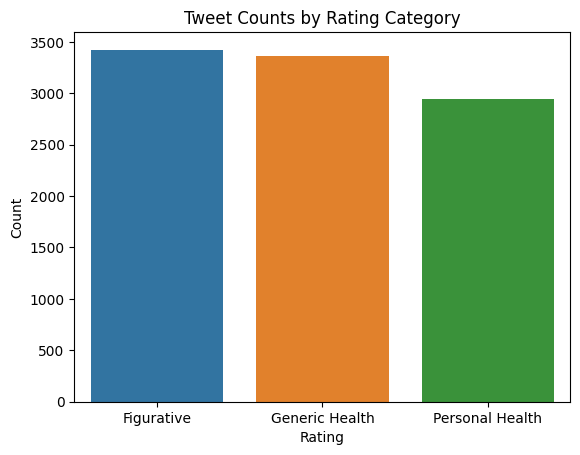

In [14]:
rating_counts = df['rating'].value_counts()

# Create a bar plot
sns.barplot(x=rating_counts.index, y=rating_counts.values)

# Adding labels for clarity
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Tweet Counts by Rating Category')
plt.xticks(ticks=[0, 1, 2], labels=['Figurative', 'Generic Health', 'Personal Health'])

# Show the plot
plt.show()

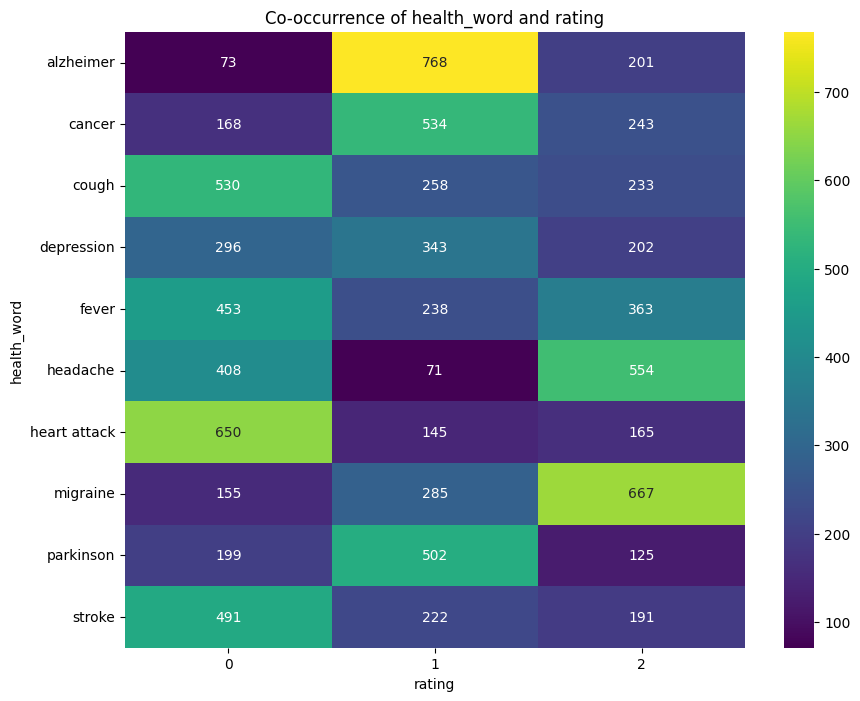

In [ ]:
#take a look at the final distribution
cross_tab = pd.crosstab(df['health_word'], df['rating'])

# Visualize the cross-tabulation as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap='viridis', fmt='g')
plt.title('Co-occurrence of health_word and rating')
plt.show()

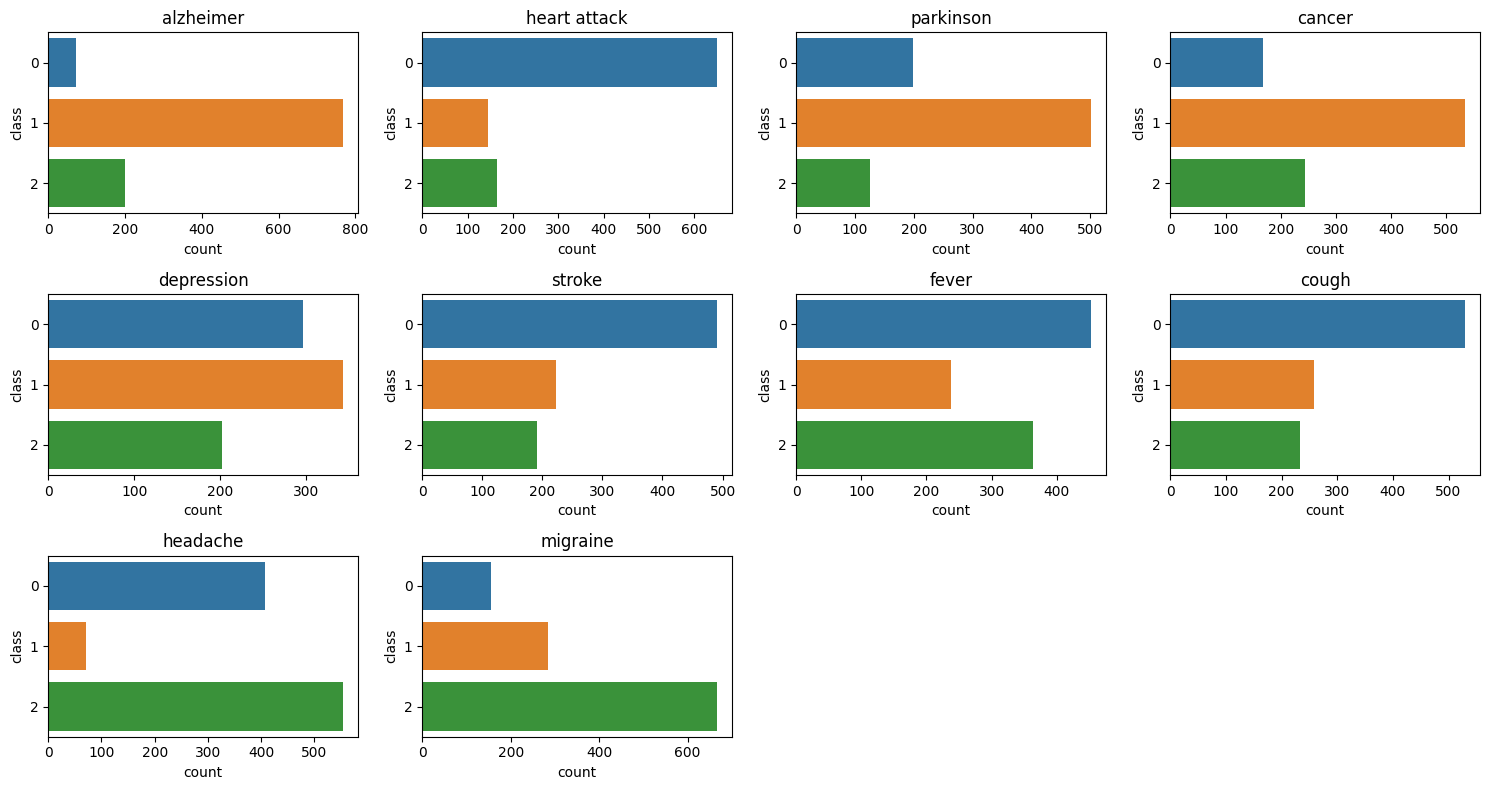

In [ ]:
health_terms=df.health_word.unique()
fig, axs = plt.subplots(3,4, figsize=(15,8))
axs_flat = axs.flatten()

for i, term in enumerate(health_terms):
    sns.countplot(data=df.loc[df['health_word'] == term], y='rating', ax=axs_flat[i])
    axs_flat[i].set_title(term)
    axs_flat[i].set_ylabel(f'class')

#remove the extra subplots which are not needed
for ax in axs_flat[10:]:
    ax.remove()

plt.tight_layout()
plt.show()